# Signal peptide figure

In [39]:
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cwd = os.getcwd()
if cwd.endswith('notebook/figure1'):
    os.chdir('../..')
    cwd = os.getcwd()
    print(f'Working directory: {cwd}')

sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2)
palette = sns.color_palette().as_hex()

data_folder = Path('./data')
assert data_folder.is_dir()

figures_folder = Path('./figures')
assert figures_folder.is_dir()

## Data prep

### Load signalP output

Generated from script `src/predict_signalp.py`

In [40]:
signalp_output = pd.read_csv(data_folder / 'signalp6_output.csv')
signalp_output['assembly_accession'] = signalp_output['protein_id'].apply(
    lambda p: p.split('@')[1] if '@' in p else None
)
signalp_output['protein_id'] = signalp_output['protein_id'].apply(
    lambda p: p.split('@')[0] if '@' in p else p
)
signalp_output['pathway'] = signalp_output['signal_peptide'].apply(lambda sp: sp.split('/')[0])
signalp_output.head()

,protein_id,signal_peptide,probability,cleavage_site,cleavage_site_prob,assembly_accession,pathway
0,BAC24414.1,Sec/SPII,0.987955,24-25,0.966853,GCA_000008885.1,Sec
1,BAF58967.1,Sec/SPII,0.685612,22-23,0.602861,GCA_000010565.1,Sec
2,BAF61015.1,Sec/SPI,0.998938,33-34,0.969633,GCA_000010565.1,Sec
3,BAG83382.1,Sec/SPI,0.786221,29-30,0.700540,GCA_000010645.1,Sec
4,ABG39042.1,Sec/SPI,0.868330,44-45,0.823325,GCA_000014225.1,Sec


### Load assembly metadata

In [46]:
gtdb_metadata = pd.read_csv(Path('../assemblies/data/') / 'gtdb_metadata.csv')
gtdb_metadata['domain'] = gtdb_metadata['gtdb_taxonomy'].apply(lambda t: t.split(';')[0].replace('d__', ''))
gtdb_metadata['gtdb_phylum'] = gtdb_metadata['gtdb_taxonomy'].apply(lambda t: t.split(';')[1].replace('p__', ''))
gtdb_metadata['gtdb_class'] = gtdb_metadata['gtdb_taxonomy'].apply(lambda t: t.split(';')[2].replace('c__', ''))
gtdb_metadata['gtdb_order'] = gtdb_metadata['gtdb_taxonomy'].apply(lambda t: t.split(';')[3].replace('o__', ''))
gtdb_metadata['gtdb_family'] = gtdb_metadata['gtdb_taxonomy'].apply(lambda t: t.split(';')[4].replace('f__', ''))
gtdb_metadata['gtdb_genus'] = gtdb_metadata['gtdb_taxonomy'].apply(lambda t: t.split(';')[5].replace('g__', ''))
gtdb_metadata['gtdb_species'] = gtdb_metadata['gtdb_taxonomy'].apply(lambda t: t.split(';')[6].replace('s__', ''))
gtdb_metadata = gtdb_metadata.set_index('ncbi_accession', drop=True)
print(len(gtdb_metadata))

54407


In [45]:
[gtdb_metadata.columns[i] for i in (62,66,75,83,84)]

['ncbi_ncrna_count',
 'ncbi_rrna_count',
 'ncbi_ssu_count',
 'ncbi_translation_table',
 'ncbi_trna_count']

### Add domain information to signalP output

In [42]:
signalp_dataset = pd.merge(
    signalp_output,
    gtdb_metadata[['assembly_accession', 'domain']],
    on='assembly_accession',
    how='inner',
)
signalp_dataset.head()

,protein_id,signal_peptide,probability,cleavage_site,cleavage_site_prob,assembly_accession,pathway,domain
0,BAC24414.1,Sec/SPII,0.987955,24-25,0.966853,GCA_000008885.1,Sec,Bacteria
1,BAF58967.1,Sec/SPII,0.685612,22-23,0.602861,GCA_000010565.1,Sec,Bacteria
2,BAF61015.1,Sec/SPI,0.998938,33-34,0.969633,GCA_000010565.1,Sec,Bacteria
3,BAG83382.1,Sec/SPI,0.786221,29-30,0.700540,GCA_000010645.1,Sec,Bacteria
4,ABG39042.1,Sec/SPI,0.868330,44-45,0.823325,GCA_000014225.1,Sec,Bacteria


## Bar plot: distribution of signal peptide types in each domain

In [43]:
pathway_per_domain = signalp_dataset[
    ['domain', 'pathway', 'assembly_accession']
].groupby(
    ['domain', 'pathway']
).nunique().sort_values('assembly_accession', ascending=False)

def total_per_domain_fn():
    total_bacteria = pathway_per_domain.loc['Bacteria'].sum()
    total_archaea = pathway_per_domain.loc['Archaea'].sum()

    def fn(row):
        domain, _ = row.name
        return  total_bacteria if domain == 'Bacteria' else total_archaea

    return fn

pathway_per_domain['total'] = pathway_per_domain.apply(total_per_domain_fn(), axis=1)
pathway_per_domain['percent'] = (100 * pathway_per_domain['assembly_accession'] / pathway_per_domain['total']).round(2)

pathway_per_domain

assembly_accession  total  percent
domain   pathway                                    
Bacteria Sec                   34972  38170    91.62
         Tat                    3198  38170     8.38
Archaea  Sec                      36     55    65.45
         Tat                      19     55    34.55

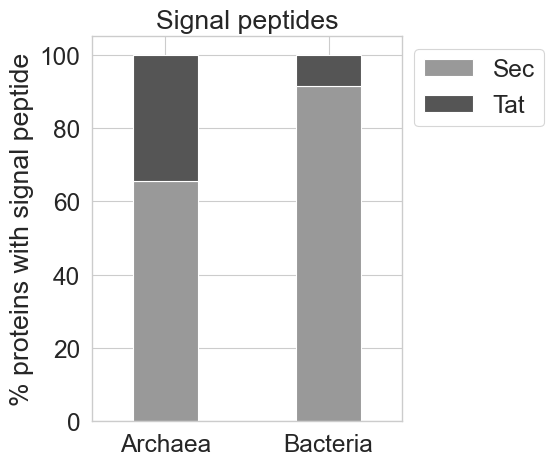

In [44]:
pivot_df = pathway_per_domain.reset_index().pivot(index='domain', columns='pathway', values='percent')

f, ax = plt.subplots(1, 1, figsize=(4, 5))

pivot_df.plot(kind='bar', stacked=True, ax=ax, color=['#999999', '#555555', '#111111'], width=0.4);

ax.set_xlabel('');
ax.set_ylabel('% proteins with signal peptide');

plt.xticks(rotation=0);

ax.legend(bbox_to_anchor=(1, 1), loc='upper left');

ax.set_title('Signal peptides');

f.savefig(figures_folder / 'figure1' / 'signal_peptides.pdf', dpi=300, bbox_inches='tight');